                                               ID 5059 P1
                                                200024763
                                                2021.3.7
                                                

## Introduction
This is about ID5059 Practical 1. Following is an explination of the process.
## Frame the problem
This is a regression problem and plain batch learning should be fine, which is using estate type, property type and property location to predict the price of the property;
## Get the data and expolre the data 

In [1]:
#The data used at present is ppsplit-ac.csv because the 4GB data is too large to fit the memory of my laptop; I tried it at first
#then I borrowed a better computer to run the whole file. #1. Import libraries;
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#2. Read csv file;
data_path = r"C:\Users\Ang Li\Desktop\pp-complete.csv"

    # add headers to columns
data_ac = pd.read_csv(data_path, names=["1","price","3","4","property type","6","estate type","8","9","10","11","location","13","14","15","16"])

    # TEST: print(data_ac.columns)

#3. By using .info() to present data and observe it;
    #observation: 
        #from the information table, we can tell that columns 2, 5, 7, 9 are saturated. 
data_ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25836876 entries, 0 to 25836875
Data columns (total 16 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   1              object
 1   price          int64 
 2   3              object
 3   4              object
 4   property type  object
 5   6              object
 6   estate type    object
 7   8              object
 8   9              object
 9   10             object
 10  11             object
 11  location       object
 12  13             object
 13  14             object
 14  15             object
 15  16             object
dtypes: int64(1), object(15)
memory usage: 3.1+ GB


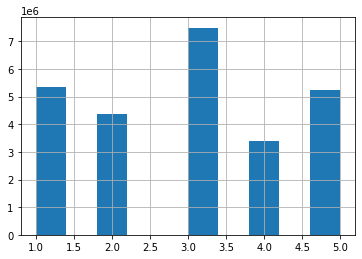

In [2]:
#4. Stratified sampling - I divide the columns according to the plot, 
#which means most of the price is under 20000 so I slice up it;

data_ac["price_cat"] = pd.cut(data_ac["price"], bins = [0, 70000, 110000, 190000, 250000, np.inf], labels = [1,2,3,4,5])
    #TEST: data_ac["price_cat"].value_counts()
    
    #TEST: 
data_ac["price_cat"].hist()
    #TEST: 
plt.show()

from sklearn.model_selection import StratifiedShuffleSplit
ac_new = StratifiedShuffleSplit(
    n_splits = 1, 
    test_size = 0.4, 
    random_state = 314)

for train_index, test_index in ac_new.split(data_ac, data_ac["price_cat"]):
    strat_test_set = data_ac.loc[test_index]
    strat_train_set = data_ac.loc[train_index]

strat_test_set.drop(['price_cat'],axis=1, inplace = True)    
strat_train_set.drop(['price_cat'],axis=1, inplace = True)

    #copy a strat_train_set and set labels
data_ac = strat_train_set.copy()
data_ac_labels = data_ac["price"].copy()
data_ac.drop("price", axis = 1, inplace = True)

## Prepare the data

In [3]:
#1.data cleaning: I chose to drop irrelevant columns instead of fill null values with median values.
    #Becasue there is no need to fulfill values, calculate columns or scaling multiple columns.
    #So I did not chose to custom a transformer.
data_ac.drop(["1","3","4","6","8","9","10","11","13","14","15","16"], axis =1, inplace = True)
    # TEST: data_ac
    
    
#2.pipline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

attributes = ['property type','estate type','location']

cat_pipeline = ColumnTransformer([
    ('1hot', OneHotEncoder(),attributes),
])


# Because of the volum of the data set is too big, 
# I change the values in location not equal to "LONDON" to "NOT LONDON", which turns it into a catogary data type. 

data_ac.loc[(data_ac.location != 'LONDON'),'location']='NOT LONDON'

    #Test: data_ac
    #TEST: data_ac["property type"].value_counts()
    #TEST: data_ac["estate type"].value_counts()
    #TEST: data_ac["location"].value_counts()

data_prepared = cat_pipeline.fit_transform(data_ac)

# following is code when I have not using a pipline and transform every attribute seperately: 
    #cat_encoder = OneHotEncoder()
    #property_cat = data_ac[["property type"]]
    #property_cat_1hot = cat_encoder.fit_transform(property_cat)

    #estate_cat = data_ac[["estate type"]]
    #estate_cat_1hot = cat_encoder.fit_transform(estate_cat)

    #location_cat = data_ac[["location"]]
    #location_cat_1hot = cat_encoder.fit_transform(location_cat)

    #TEST: data_ac
    #TEST: location_cat_1hot


## Explore Models 

In [4]:
#1. train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(data_prepared, data_ac_labels)

    #TEST: some_data = data_ac.iloc[:5]
    #TEST: some_labels = data_ac_labels.iloc[:5]
    #TEST: some_data_prepared = cat_pipeline.transform(some_data)
    #TEST: print("Prindictions:\t", tree_reg.predict(some_data_prepared))
    #TEST: print("Lables:\t\t", list(some_labels))
    
#2. using rmse, mean and R^2 to evaluate
from sklearn.metrics import mean_squared_error
data_predictions = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_ac_labels, data_predictions)
tree_rmse = np.sqrt(tree_mse)
np.round(tree_rmse)

750586.0

In [5]:
from sklearn.metrics import r2_score
r2_score(data_ac_labels, data_predictions)

0.051991185593590505

In [6]:
#3. Cross-Validation
from sklearn.model_selection import cross_val_score
k = 10
scores = cross_val_score(tree_reg, data_prepared, data_ac_labels,scoring="neg_mean_squared_error", cv = k)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("scores:",np.round(scores))
    print("mean:",np.round(scores.mean()))
    print("standard deviation:",scores.std())

display_scores(rmse_scores)

scores: [672793. 655695. 659181. 795730. 764808. 841720. 720563. 686428. 845694.
 828162.]
mean: 747078.0
standard deviation: 73426.55949822486


## Fine-tune models and running on the test set

The part to find a better modle is omitted as required. Following is evaluation on test set. 

In [7]:
#1. data preparetion
x_test = strat_test_set.drop("price", axis = 1)
y_test = strat_test_set["price"].copy()

x_test.drop(["1","3","4","6","8","9","10","11","13","14","15","16"], axis =1, inplace = True)

x_test.loc[(x_test.location != 'LONDON'),'location']='NOT LONDON'

x_test_prepared = cat_pipeline.transform(x_test)

In [8]:
# TEST: x_test["estate type"].value_counts()

In [9]:
# modeling
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(x_test_prepared, y_test)

#rmse evaluation
from sklearn.metrics import mean_squared_error
x_test_predictions = tree_reg.predict(x_test_prepared)
final_mse = mean_squared_error(y_test, x_test_predictions)
final_rmse = np.sqrt(final_mse)
np.round(final_rmse)

782874.0

In [10]:
#RMSFE evaluation
SE = (x_test_predictions - y_test)
SFE = SE.divide(y_test**2)
MSFE = SFE.mean()
RMSFE = np.sqrt(MSFE)
RMSFE

0.894338736789097

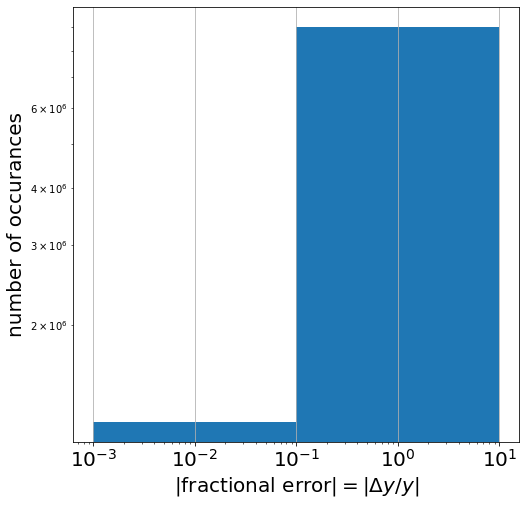

In [11]:
#residuals plot - which is little weird
FEN = np.abs(x_test_predictions - y_test)
FED = np.abs(y_test)
FE = FEN.divide(FED)
logbins = np.logspace(-3,1,3,100)
ax = FE.hist(bins = logbins,figsize = (8,8))
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("|fractional error|$ = |\Delta y/y |$",size = 20)
plt.xticks(fontsize = 20)
plt.ylabel("number of occurances", size = 20)
plt.yticks(fontsize = 20)
plt.show()

## Present solution
The summary is write on a seperate pdf file. 